GPCC precipitation data (original distributor): https://opendata.dwd.de/climate_environment/GPCC/html/fulldata-monthly_v2022_doi_download.html

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc

# Graphic
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import seaborn as sns
from cartopy.crs import EqualEarth, PlateCarree
import geopandas as gpd
from shapely.geometry import Point

# PCA/EOF Analysis
from xeofs.models import EOF, EOFRotator, ExtendedEOF

# Statistics
from scipy import stats
from scipy.interpolate import griddata

In [2]:
# Set graphic style
plt.style.use('seaborn')

C:\Users\mathe\AppData\Local\Temp\ipykernel_18736\3617314069.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
def plot_basemap(df, score, title, score_name, grid_size=1000, llcrnrlon=-180, llcrnrlat=-75, urcrnrlon=180, urcrnrlat=85, figsize_x=15, figsize_y=15):
    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)

    fig, ax = plt.subplots(figsize=(figsize_x, figsize_y), dpi=800)

    # Extract longitude, latitude, and scores
    longitudes = gdf['lon'].values
    latitudes = gdf['lat'].values
    scores = gdf[score].values

    # Set up the Basemap
    m = Basemap(projection='cyl', llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat, urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat, resolution='i', ax=ax)

    # Generate a grid
    lon_grid = np.linspace(longitudes.min(), longitudes.max(), grid_size)
    lat_grid = np.linspace(latitudes.min(), latitudes.max(), grid_size)
    lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

    # Interpolate the scores onto the grid
    score_grid = griddata((longitudes, latitudes), scores, (lon_mesh, lat_mesh), method='linear')

    # Convert the grid to map coordinates
    x, y = m(lon_mesh, lat_mesh)

    # Draw map boundaries and features
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries(linewidth=1, linestyle='solid', color='k')

    # Plot the filled contour map
    cs = m.contourf(x, y, score_grid, cmap='jet', levels=300)

    plt.ylabel("Latitude", fontsize=15, labelpad=35)
    plt.xlabel("Longitude", fontsize=15, labelpad=20)
    cbar = m.colorbar(cs, location='right', pad="3%")
    cbar.set_label(score_name, fontsize=13)
    plt.title(title, fontsize=15)

    # Display the plot
    plt.show()

# Precipitation data preprocessing (SPI + regional precipitation series)

In [4]:
def nc_to_pandas(fp: str) -> pd.DataFrame:
    ds = xr.open_dataset(fp)
    df = ds.to_dataframe()
    return df.reset_index()

In [5]:
file_paths = [
    '../data/gpcc_data/full_data_monthly_v2022_1921_1930_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_1931_1940_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_1941_1950_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_1951_1960_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_1961_1970_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_1971_1980_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_1981_1990_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_1991_2000_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_2001_2010_25.nc',
    '../data/gpcc_data/full_data_monthly_v2022_2011_2020_25.nc'
]

dfs = [nc_to_pandas(fp) for fp in file_paths]
df = pd.concat(dfs)[['lon', 'lat', 'time', 'precip']]

# Sorting by 'time' to ensure continuity
df = df.sort_values(by='time').reset_index(drop=True)

In [6]:
df

,lon,lat,time,precip
0,-178.75,88.75,1921-01-01,NaN
1,-11.25,-18.75,1921-01-01,NaN
2,-163.75,-33.75,1921-01-01,NaN
3,98.75,-63.75,1921-01-01,NaN
4,-11.25,-21.25,1921-01-01,NaN
...,...,...,...,...
12441595,-93.75,56.25,2020-12-01,18.93
12441596,138.75,-41.25,2020-12-01,NaN
12441597,-93.75,53.75,2020-12-01,6.81
12441598,-93.75,66.25,2020-12-01,15.67


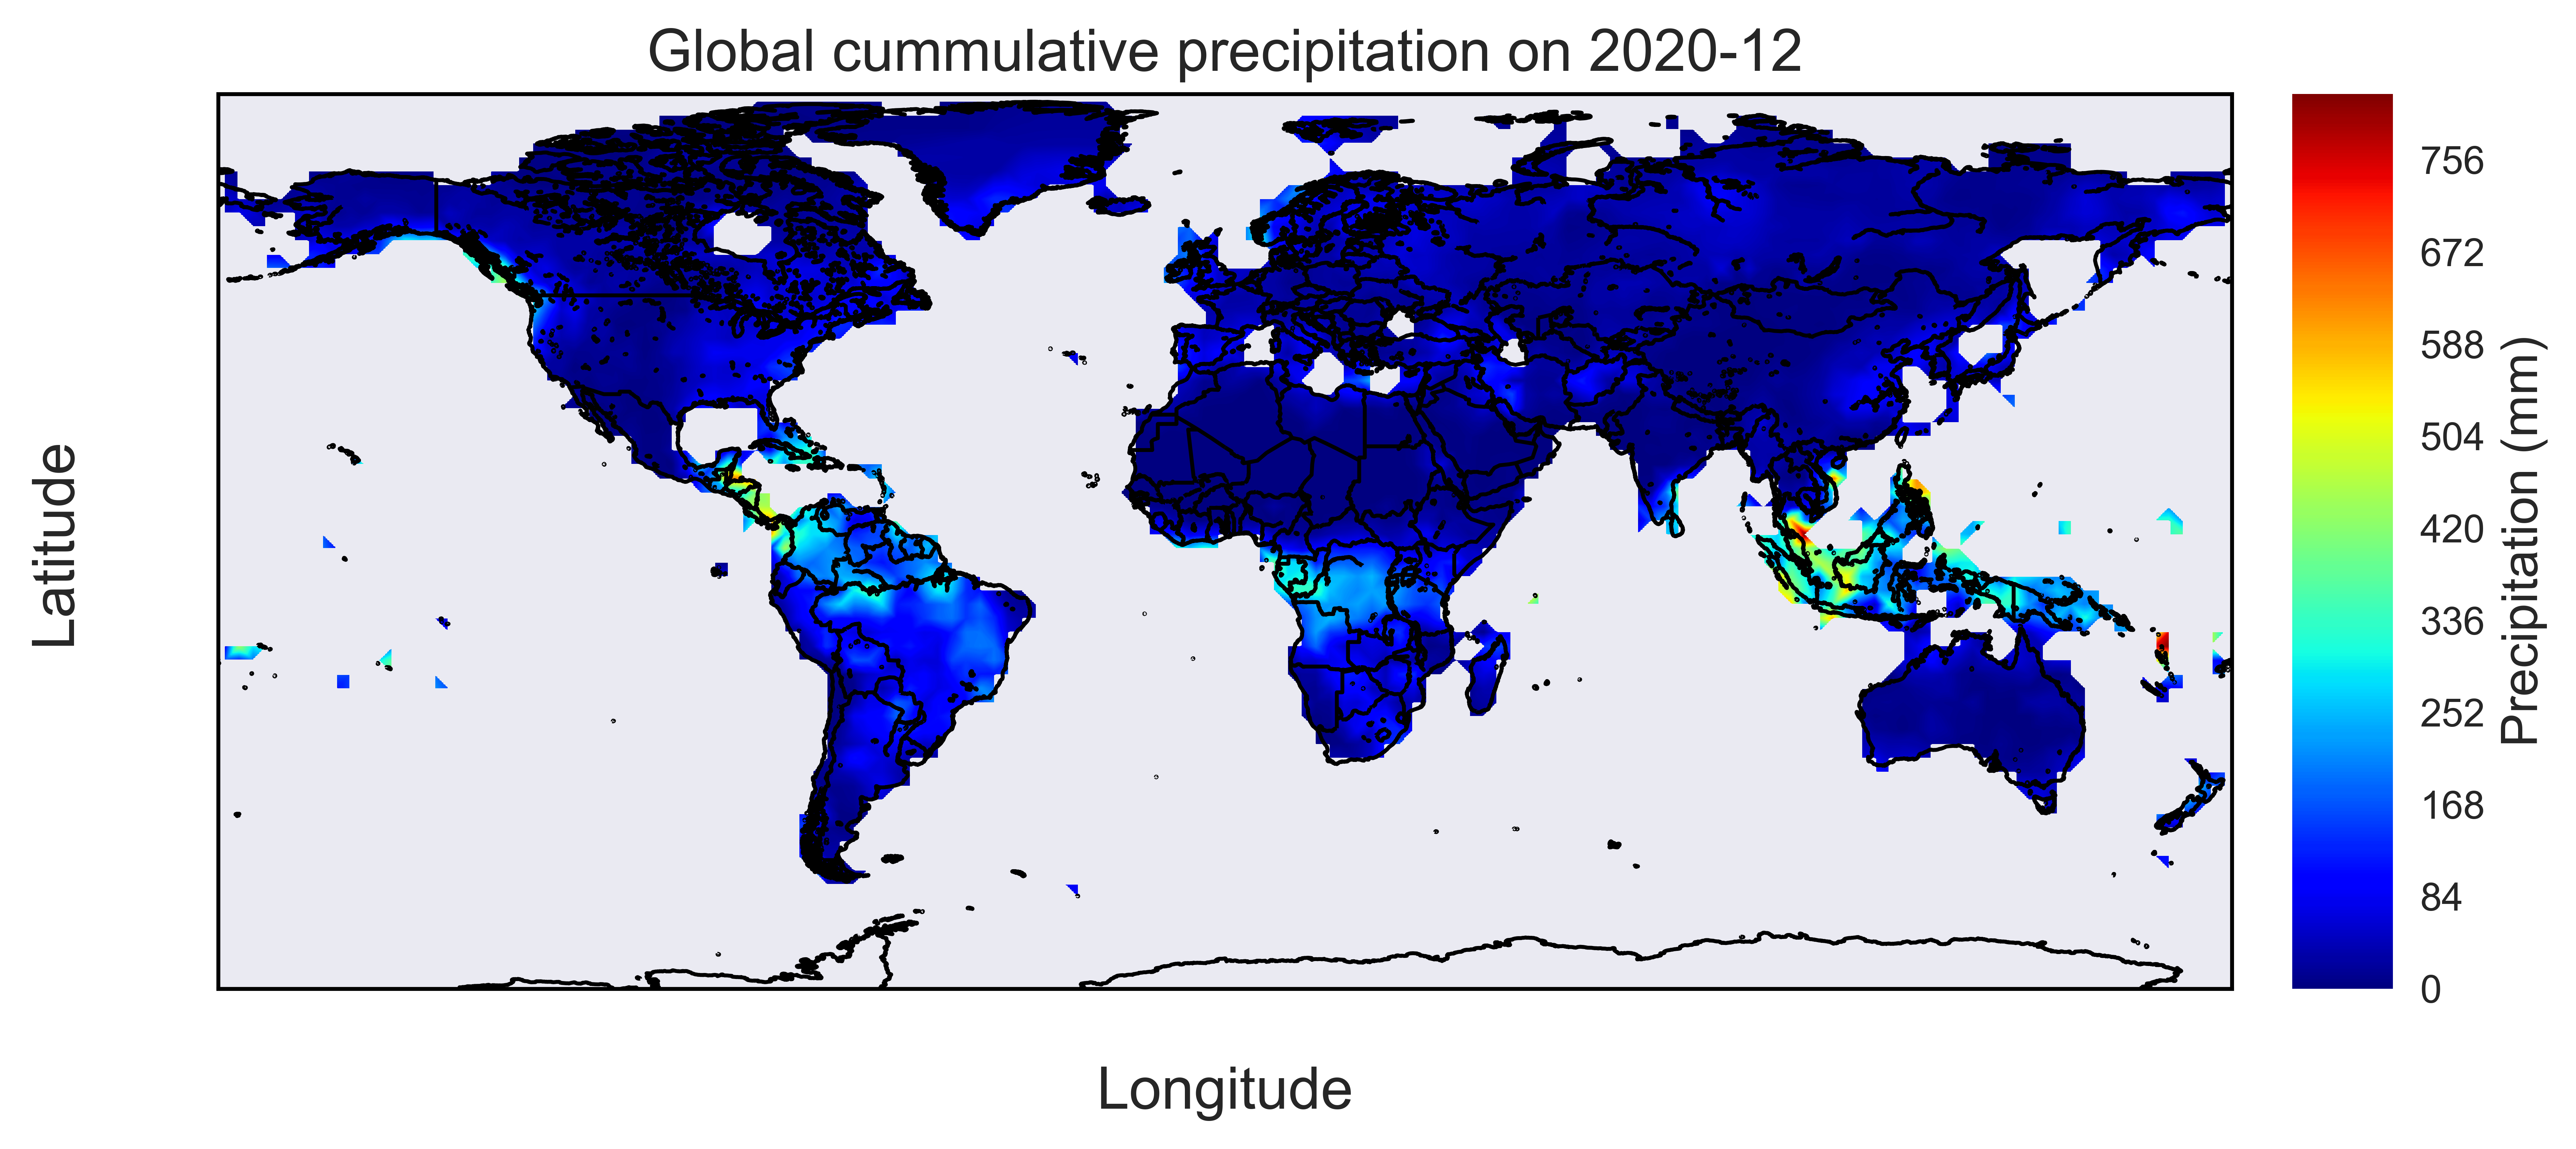

In [7]:
plot_basemap(df=df[df['time'] == '2020-11-01'],
             title='Global cummulative precipitation on 2020-12',
             score='precip',
             score_name='Precipitation (mm)',
             grid_size=1000,
             figsize_x=10,
             figsize_y=5)

In [7]:
central_amazon_data = df[(df['lat']<=1.25) & (df['lat']>=-11.25) & (df['lon']>=-71.25) & (df['lon']<=-53.75)]

In [8]:
central_amazon_data.isnull().sum()

lon       0
lat       0
time      0
precip    0
dtype: int64

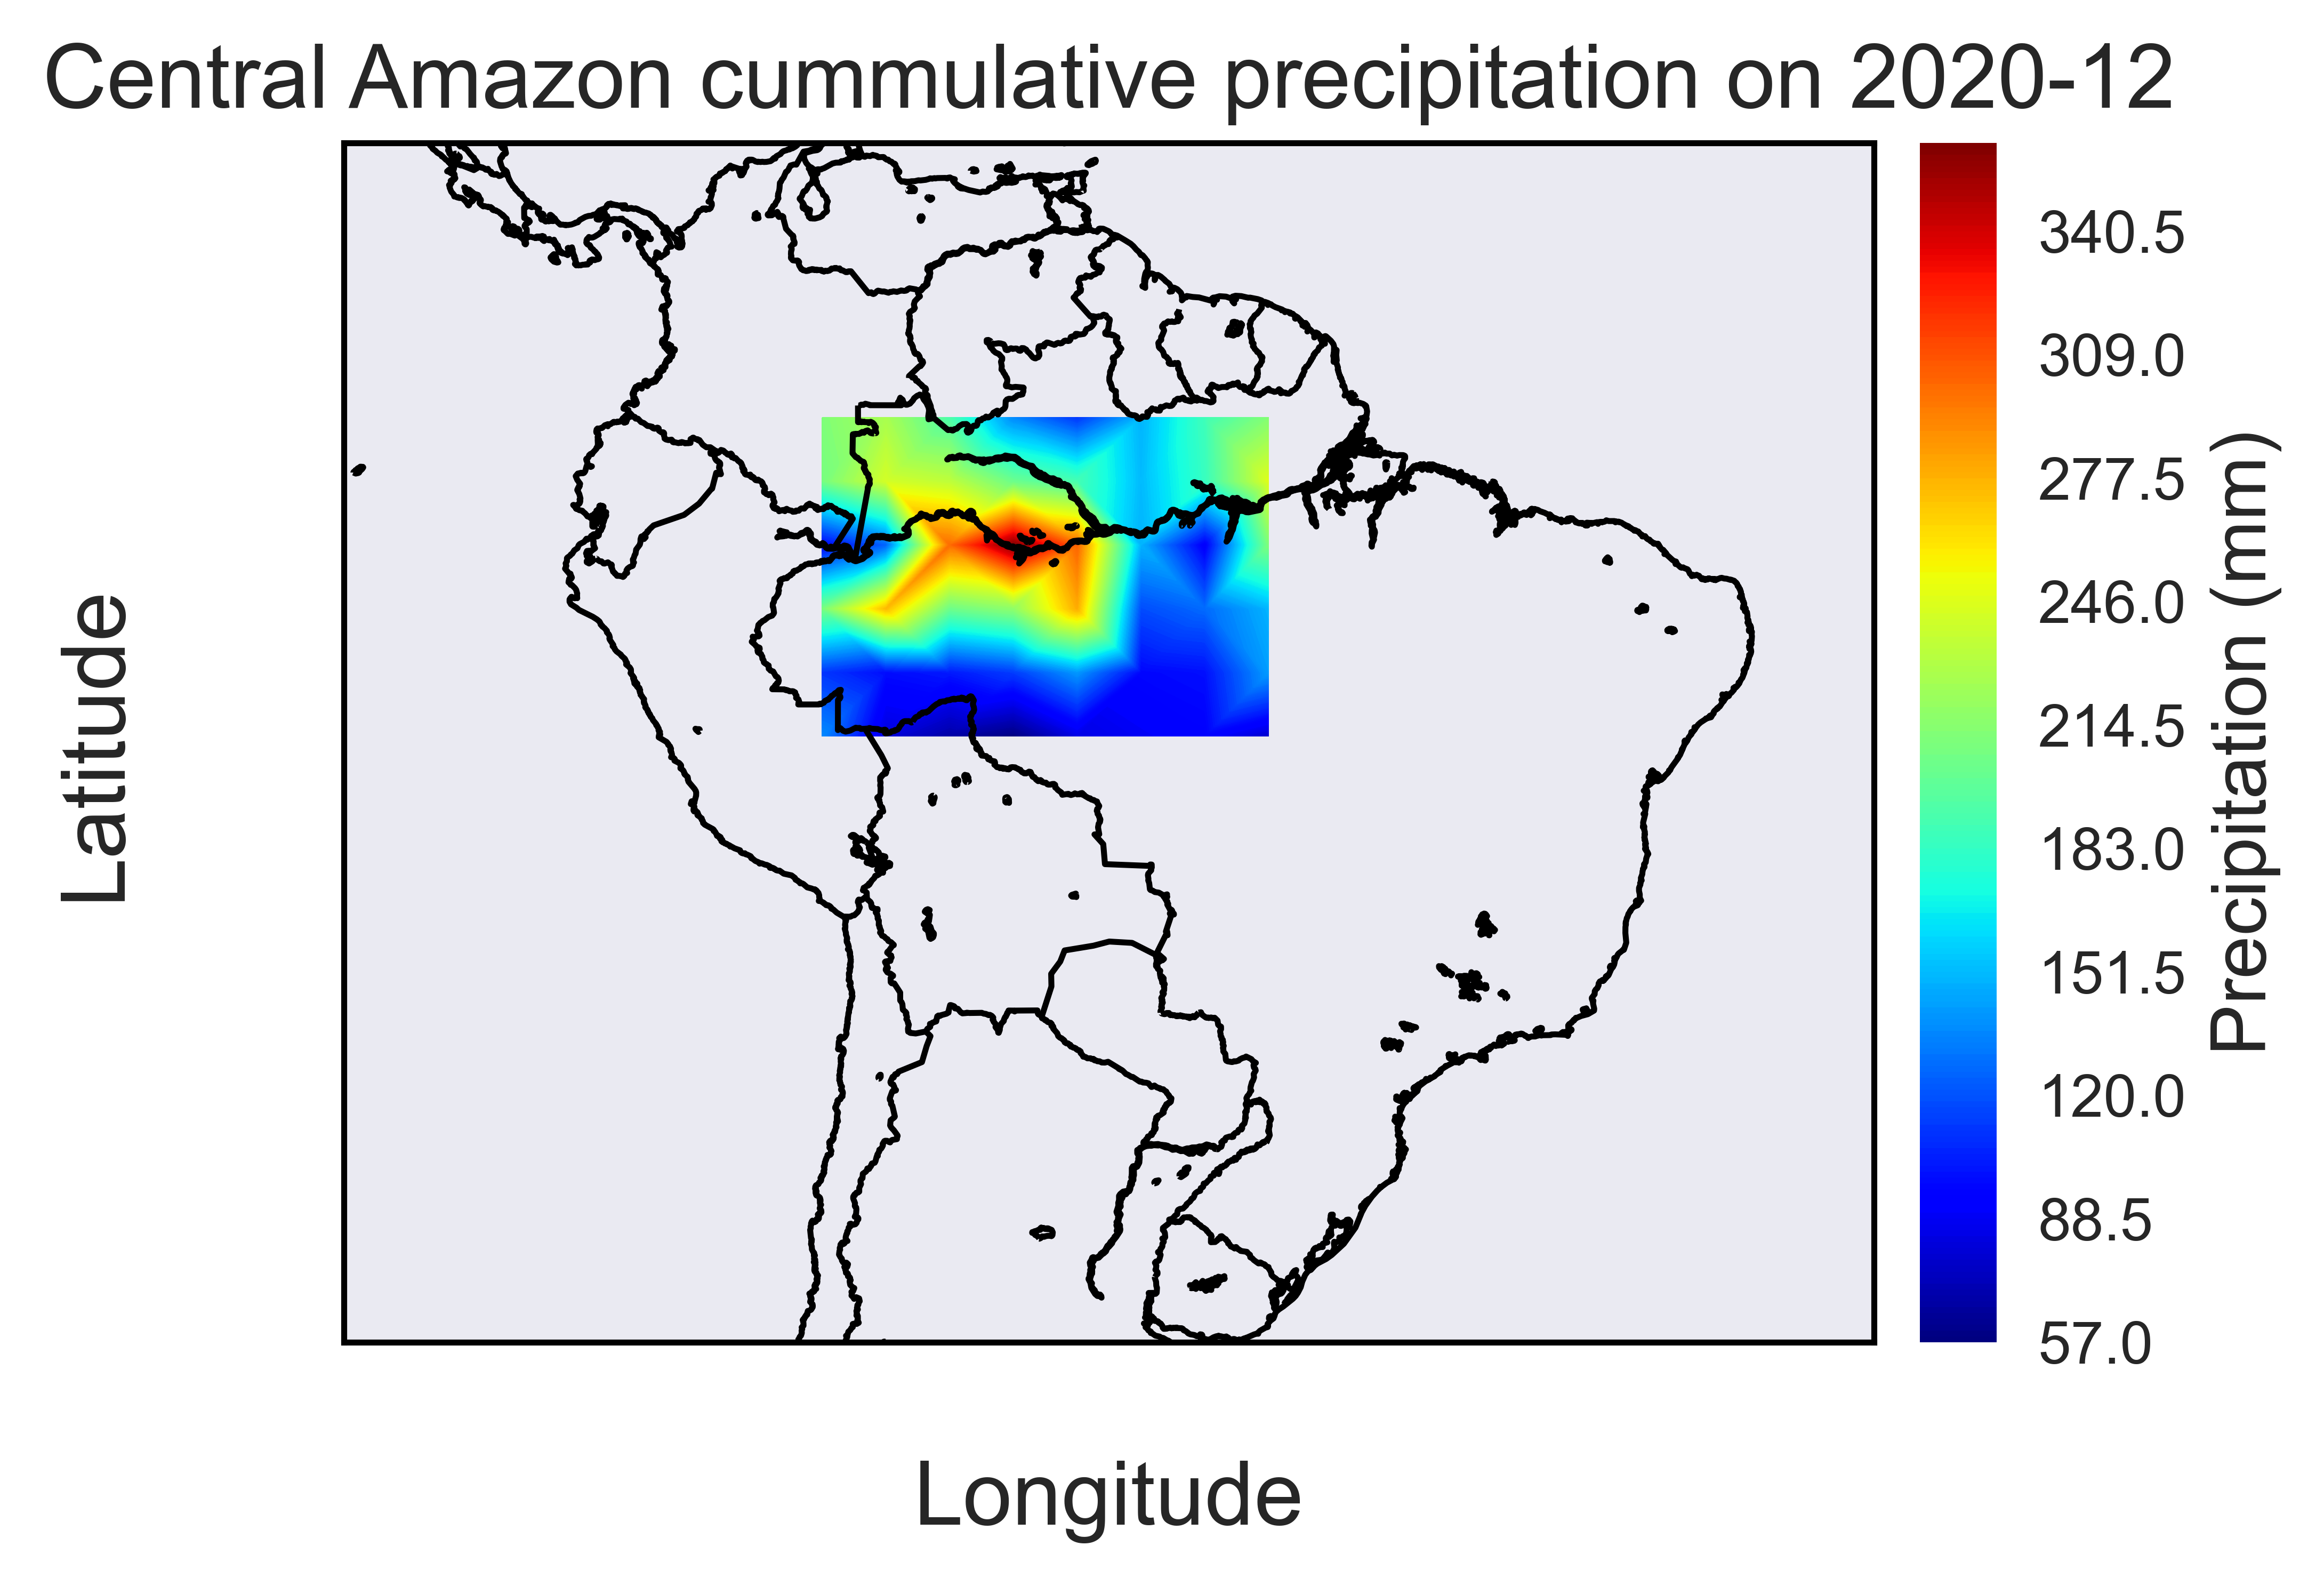

In [9]:
plot_basemap(df=central_amazon_data[central_amazon_data['time'] == '2020-11-01'],
             title='Central Amazon cummulative precipitation on 2020-12',
             score='precip',
             score_name='Precipitation (mm)',
             grid_size=1000,
             llcrnrlon=-90, 
             llcrnrlat=-35, 
             urcrnrlon=-30, 
             urcrnrlat=12,
             figsize_x=5,
             figsize_y=5)

## SPI calculation functions

In [10]:
def standardization(value, params):
    cdf_value = stats.gamma.cdf(value, *params)
    norm_spi = stats.norm.ppf(cdf_value, loc=0, scale=1)
    return norm_spi

def gamma_params(x, initial_est=True):
    if x.isna().sum() > 0:
        return [np.nan, np.nan, np.nan]
    elif initial_est:
        # Calculate sample mean and variance
        mean = np.mean(x)
        variance = np.var(x)

        # Calculate initial estimates for the gamma parameters
        initial_scale = variance/mean
        initial_loc = 0  # assuming data is not shifted

        # Fit the gamma distribution to the data using initial estimates
        try:
            shape, loc, scale = stats.gamma.fit(x, loc=initial_loc, scale=initial_scale)
        except:
            print('Failed to converge to distribution parameter domain')
            return [np.nan, np.nan, np.nan]
        return [shape, loc, scale]
    else:
        shape, loc, scale = stats.gamma.fit(x)
        return [shape, loc, scale]

def spi_table(initial_precip_table, fit_period=12, initial_est=True):

    precip_table = initial_precip_table.copy()
    precip_table.loc[:,'cumulative_precip'] = np.nan
    precip_table.loc[:,'SPI'] = np.nan

    iters = len(precip_table['lat'].unique())*len(precip_table['lon'].unique())
    print('Total iterations:', iters, '\n\n')
    counter = 0

    for lat in precip_table['lat'].unique():
        for lon in precip_table['lon'].unique():

            aux_df = pd.DataFrame()
            series = precip_table[(precip_table['lat']==lat) & (precip_table['lon']==lon)]['precip']

            # 12 months (1 year) cumulative precipitation
            aux_df.loc[:, 'cumulative_precip'] = series.rolling(fit_period, center=False).sum()

            # Fit gamma distribution for 12 months cumulative precipitation considering 360 months offset from t-12 backwards
            aux_df.loc[:,'gamma_params'] = [gamma_params(x, initial_est) for x in aux_df['cumulative_precip'].shift(12).rolling(window=360, center=False)]

            # Obtain spi using the gamma parameters fitted and the current 12 month precipitation value
            spi_value = aux_df.apply(lambda x: standardization(x.cumulative_precip, x.gamma_params), axis=1)

            # Sets the obtained SPI values on the final table
            precip_table.loc[(precip_table['lat']==lat) & (precip_table['lon']==lon), 'cumulative_precip'] = aux_df['cumulative_precip']
            precip_table.loc[(precip_table['lat']==lat) & (precip_table['lon']==lon), 'SPI'] = spi_value

            del aux_df

            counter+=1
            print('\nLat: ', lat, '  Lon: ', lon)
            print('Completeness', round(counter/iters, 4))
            
    return precip_table

<br>
<br>

### SPI based on 12 months cumulative rain

In [11]:
ca_precip_table = spi_table(central_amazon_data, fit_period=12)

Total iterations: 48 



Lat:  1.25   Lon:  -58.75
Completeness 0.0208

Lat:  1.25   Lon:  -56.25
Completeness 0.0417

Lat:  1.25   Lon:  -63.75
Completeness 0.0625

Lat:  1.25   Lon:  -61.25
Completeness 0.0833

Lat:  1.25   Lon:  -53.75
Completeness 0.1042

Lat:  1.25   Lon:  -68.75
Completeness 0.125

Lat:  1.25   Lon:  -71.25
Completeness 0.1458

Lat:  1.25   Lon:  -66.25
Completeness 0.1667

Lat:  -1.25   Lon:  -58.75
Completeness 0.1875

Lat:  -1.25   Lon:  -56.25
Completeness 0.2083

Lat:  -1.25   Lon:  -63.75
Completeness 0.2292

Lat:  -1.25   Lon:  -61.25
Completeness 0.25

Lat:  -1.25   Lon:  -53.75
Completeness 0.2708

Lat:  -1.25   Lon:  -68.75
Completeness 0.2917

Lat:  -1.25   Lon:  -71.25
Completeness 0.3125

Lat:  -1.25   Lon:  -66.25
Completeness 0.3333

Lat:  -3.75   Lon:  -58.75
Completeness 0.3542

Lat:  -3.75   Lon:  -56.25
Completeness 0.375

Lat:  -3.75   Lon:  -63.75
Completeness 0.3958

Lat:  -3.75   Lon:  -61.25
Completeness 0.4167

Lat:  -3.75   Lon:  -53.75


c:\Users\mathe\my_git_repositories\climate-data-preprocessing\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:406: RuntimeWarning: invalid value encountered in scalar divide
  return m3 / np.power(m2, 1.5)


Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to co

In [12]:
ca_precip_table.to_csv('../data/processed/central_amazon_spi_12_gpcc.csv', index=False)

In [13]:
drought_series = ca_precip_table[['lat', 'lon', 'time', 'SPI']].copy()

In [14]:
k = -1
drought_series['drought'] = drought_series['SPI'].apply(lambda x: 1 if x <= k else 0)

<Axes: xlabel='time'>

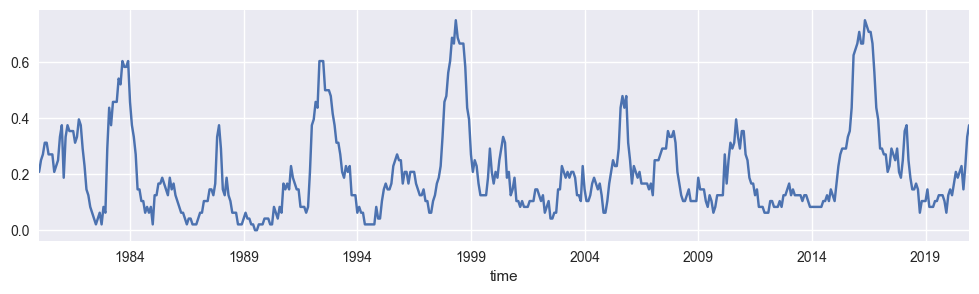

In [18]:
# drought_series[['time', 'drought']].groupby('time').apply(np.mean).plot(figsize=(12,3))
drought_series[['time', 'drought']][drought_series['time'] >= '1980-01-01'].groupby('time').apply(np.mean).plot(figsize=(12,3))

<br>
<br>

### SPI based on 24 months cumulative rain

In [19]:
ca_precip_table = spi_table(central_amazon_data, fit_period=24)

Total iterations: 48 



Lat:  1.25   Lon:  -58.75
Completeness 0.0208

Lat:  1.25   Lon:  -56.25
Completeness 0.0417

Lat:  1.25   Lon:  -63.75
Completeness 0.0625

Lat:  1.25   Lon:  -61.25
Completeness 0.0833

Lat:  1.25   Lon:  -53.75
Completeness 0.1042

Lat:  1.25   Lon:  -68.75
Completeness 0.125

Lat:  1.25   Lon:  -71.25
Completeness 0.1458

Lat:  1.25   Lon:  -66.25
Completeness 0.1667

Lat:  -1.25   Lon:  -58.75
Completeness 0.1875

Lat:  -1.25   Lon:  -56.25
Completeness 0.2083

Lat:  -1.25   Lon:  -63.75
Completeness 0.2292

Lat:  -1.25   Lon:  -61.25
Completeness 0.25

Lat:  -1.25   Lon:  -53.75
Completeness 0.2708

Lat:  -1.25   Lon:  -68.75
Completeness 0.2917

Lat:  -1.25   Lon:  -71.25
Completeness 0.3125

Lat:  -1.25   Lon:  -66.25
Completeness 0.3333

Lat:  -3.75   Lon:  -58.75
Completeness 0.3542

Lat:  -3.75   Lon:  -56.25
Completeness 0.375

Lat:  -3.75   Lon:  -63.75
Completeness 0.3958

Lat:  -3.75   Lon:  -61.25
Completeness 0.4167

Lat:  -3.75   Lon:  -53.75


c:\Users\mathe\my_git_repositories\climate-data-preprocessing\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:406: RuntimeWarning: invalid value encountered in scalar divide
  return m3 / np.power(m2, 1.5)


Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to co

In [20]:
ca_precip_table.to_csv('../data/processed/central_amazon_spi_24_gpcc.csv', index=False)

In [21]:
drought_series = ca_precip_table[['lat', 'lon', 'time', 'SPI']].copy()

In [22]:
k = -1
drought_series['drought'] = drought_series['SPI'].apply(lambda x: 1 if x <= k else 0)

<Axes: xlabel='time'>

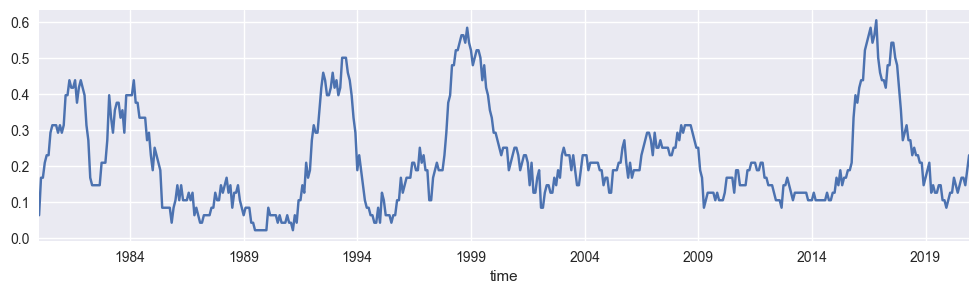

In [23]:
# drought_series[['time', 'drought']].groupby('time').apply(np.mean).plot(figsize=(12,3))
drought_series[['time', 'drought']][drought_series['time'] >= '1980-01-01'].groupby('time').apply(np.mean).plot(figsize=(12,3))

<br>
<br>

### SPI based on 36 months cumulative rain

In [24]:
ca_precip_table = spi_table(central_amazon_data, fit_period=36)

Total iterations: 48 



Lat:  1.25   Lon:  -58.75
Completeness 0.0208

Lat:  1.25   Lon:  -56.25
Completeness 0.0417

Lat:  1.25   Lon:  -63.75
Completeness 0.0625

Lat:  1.25   Lon:  -61.25
Completeness 0.0833

Lat:  1.25   Lon:  -53.75
Completeness 0.1042

Lat:  1.25   Lon:  -68.75
Completeness 0.125

Lat:  1.25   Lon:  -71.25
Completeness 0.1458

Lat:  1.25   Lon:  -66.25
Completeness 0.1667

Lat:  -1.25   Lon:  -58.75
Completeness 0.1875

Lat:  -1.25   Lon:  -56.25
Completeness 0.2083

Lat:  -1.25   Lon:  -63.75
Completeness 0.2292

Lat:  -1.25   Lon:  -61.25
Completeness 0.25

Lat:  -1.25   Lon:  -53.75
Completeness 0.2708

Lat:  -1.25   Lon:  -68.75
Completeness 0.2917

Lat:  -1.25   Lon:  -71.25
Completeness 0.3125

Lat:  -1.25   Lon:  -66.25
Completeness 0.3333

Lat:  -3.75   Lon:  -58.75
Completeness 0.3542

Lat:  -3.75   Lon:  -56.25
Completeness 0.375

Lat:  -3.75   Lon:  -63.75
Completeness 0.3958

Lat:  -3.75   Lon:  -61.25
Completeness 0.4167

Lat:  -3.75   Lon:  -53.75


c:\Users\mathe\my_git_repositories\climate-data-preprocessing\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:406: RuntimeWarning: invalid value encountered in scalar divide
  return m3 / np.power(m2, 1.5)


Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to co

In [25]:
ca_precip_table.to_csv('../data/processed/central_amazon_spi_36_gpcc.csv', index=False)

In [26]:
drought_series = ca_precip_table[['lat', 'lon', 'time', 'SPI']].copy()

In [27]:
k = -1
drought_series['drought'] = drought_series['SPI'].apply(lambda x: 1 if x <= k else 0)

<Axes: xlabel='time'>

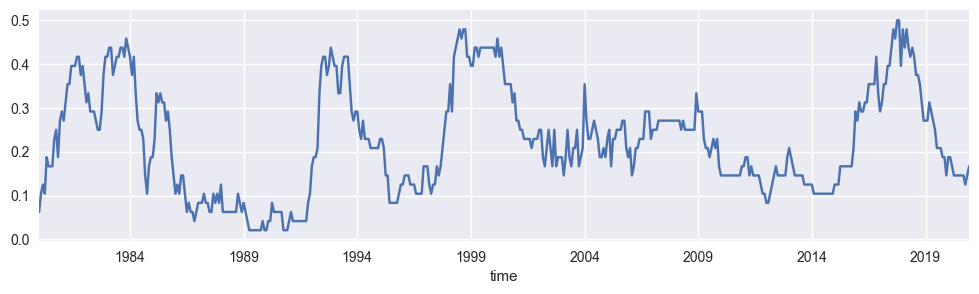

In [28]:
# drought_series[['time', 'drought']].groupby('time').apply(np.mean).plot(figsize=(12,3))
drought_series[['time', 'drought']][drought_series['time'] >= '1980-01-01'].groupby('time').apply(np.mean).plot(figsize=(12,3))

<br>
<br>

### SPI based on 48 months cumulative rain

In [29]:
ca_precip_table = spi_table(central_amazon_data, fit_period=48)

Total iterations: 48 



Lat:  1.25   Lon:  -58.75
Completeness 0.0208

Lat:  1.25   Lon:  -56.25
Completeness 0.0417

Lat:  1.25   Lon:  -63.75
Completeness 0.0625

Lat:  1.25   Lon:  -61.25
Completeness 0.0833

Lat:  1.25   Lon:  -53.75
Completeness 0.1042

Lat:  1.25   Lon:  -68.75
Completeness 0.125

Lat:  1.25   Lon:  -71.25
Completeness 0.1458

Lat:  1.25   Lon:  -66.25
Completeness 0.1667

Lat:  -1.25   Lon:  -58.75
Completeness 0.1875

Lat:  -1.25   Lon:  -56.25
Completeness 0.2083

Lat:  -1.25   Lon:  -63.75
Completeness 0.2292

Lat:  -1.25   Lon:  -61.25
Completeness 0.25

Lat:  -1.25   Lon:  -53.75
Completeness 0.2708

Lat:  -1.25   Lon:  -68.75
Completeness 0.2917

Lat:  -1.25   Lon:  -71.25
Completeness 0.3125

Lat:  -1.25   Lon:  -66.25
Completeness 0.3333

Lat:  -3.75   Lon:  -58.75
Completeness 0.3542

Lat:  -3.75   Lon:  -56.25
Completeness 0.375

Lat:  -3.75   Lon:  -63.75
Completeness 0.3958

Lat:  -3.75   Lon:  -61.25
Completeness 0.4167

Lat:  -3.75   Lon:  -53.75


c:\Users\mathe\my_git_repositories\climate-data-preprocessing\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:406: RuntimeWarning: invalid value encountered in scalar divide
  return m3 / np.power(m2, 1.5)


Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to converge to distribution parameter domain
Failed to co

In [30]:
ca_precip_table.to_csv('../data/processed/central_amazon_spi_48_gpcc.csv', index=False)

In [31]:
drought_series = ca_precip_table[['lat', 'lon', 'time', 'SPI']].copy()

In [36]:
k = -1
drought_series['drought'] = drought_series['SPI'].apply(lambda x: 1 if x <= k else 0)

<Axes: xlabel='time'>

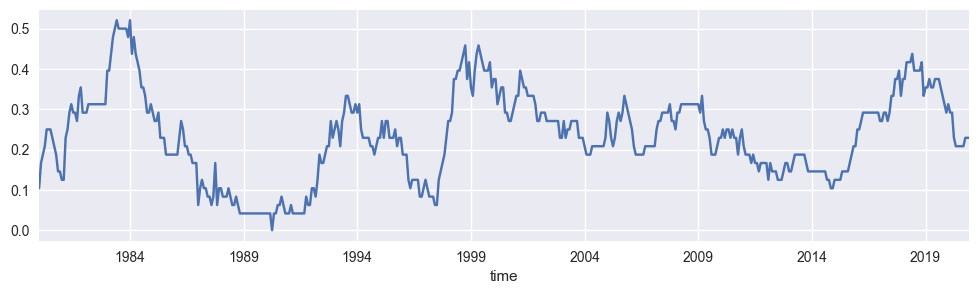

In [37]:
# drought_series[['time', 'drought']].groupby('time').apply(np.mean).plot(figsize=(12,3))
drought_series[['time', 'drought']][drought_series['time'] >= '1980-01-01'].groupby('time').apply(np.mean).plot(figsize=(12,3))